In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
folder = 'time_logs/'
file = 'allopezr_whole.txt'
mesh_folder = 'D:/allopezr/Fragments/vessels_binary/'
metadata_pattern = '*_mesh.txt'

In [3]:
# Change matplotlib style
plt.style.use('default')

font_mapping = {'family': 'Adobe Devanagari', 'weight': 'normal', 'size': 24}
plt.rc('font', **font_mapping)

In [4]:
class Event:
    def __init__(self, time, event_type):
        self.time = time / 1000
        self.event_type = event_type
        self.event_type = self.event_type.replace('_', ' ')
        self.event_type = self.event_type[0].upper() + self.event_type[1:].lower()
        
class ResourceUsage:
    def __init__(self, cpu, cpu_total, memory, memory_total, virtual_memory=.0, virtual_memory_total=.0, gpu=.0, gpu_total=.0):
        self.cpu = cpu
        self.cpu_total = cpu_total
        self.memory = memory
        self.memory_total = memory_total
        self.virtual_memory = virtual_memory
        self.virtual_memory_total = virtual_memory_total
        self.gpu = gpu
        self.gpu_total = gpu_total
        
        divisor = 1024            
        self.memory /= divisor
        self.memory_total /= divisor
        self.virtual_memory /= divisor
        self.virtual_memory_total /= divisor
        self.gpu /= divisor
        self.gpu_total /= divisor

In [5]:
events = []
resource_usage = []
file_root = []

overall_num_fragments = 0
num_fragments = [0 for _ in range(11)]

with open(folder + file, 'r') as f:
    lines = f.readlines()
    
    for line in lines:
        if '*' in line:
            time = float(line.split(':')[1].split(' ')[1])
            event_type = line.split(':')[0].split('*')[1]
            event_type = event_type.strip()
            events.append(Event(time, event_type))
        elif '-' in line:
            file_path = line.split('-')[1].strip().split('/')[-1]
            file_root.append(file_path)
            metadata = file_path.split('_')
            it = int(metadata[-1].split('i')[0])
            f = int(metadata[-3].split('f')[0])

            overall_num_fragments += f
            num_fragments[f] += f
        else:
            resources = line.split(' ')
            if len(resources) == 9:
                cpu = float(resources[0])
                cpu_total = float(resources[1])
                memory = float(resources[2])
                memory_total = float(resources[3])
                virtual_memory = float(resources[4])
                virtual_memory_total = float(resources[5])
                gpu = float(resources[6])
                gpu_total = float(resources[7])
                resource_usage.append(ResourceUsage(cpu, cpu_total, memory, memory_total, virtual_memory, virtual_memory_total, gpu, gpu_total))

In [6]:
num_fragments

[0, 0, 52600, 72588, 92576, 110460, 126240, 132552, 143072, 151488, 157800]

In [7]:
overall_num_fragments

1039376

In [8]:
overall_time = 0
print(len(events))
for i in range(0, len(events)):
    overall_time += events[i].time
    
overall_time *= 0.5
    
print(overall_num_fragments / overall_time)
print(overall_time / 60 / 60 / 24)

562821
4.960266922163527
2.4252353761574894


## Volume stats

In [9]:
import glob, os
import pandas as pd
import seaborn as sns

In [10]:
# recursive search
path = mesh_folder + '*/' + metadata_pattern
mesh_files = glob.glob(mesh_folder + '*/' + metadata_pattern, recursive=True)

In [11]:
global_df = None

for metadata_file in tqdm(mesh_files):
    df = pd.read_csv(metadata_file, sep='\t', header=0, index_col=False)
    
    # maintain only a subset of the columns
    df = df[['Filename', 'Percentage', 'Vertices', 'Faces']]
    if global_df is None:
        global_df = df
    else:
        global_df = pd.concat([global_df, df], ignore_index=True)

100%|██████████| 1052/1052 [02:00<00:00,  8.76it/s]


In [12]:
# create a new column with the number of fragments
global_df['Fragments'] = global_df['Filename'].apply(lambda x: int(x.split('f_')[0].split('_')[-1]))

In [13]:
global_df

,Filename,Percentage,Vertices,Faces,Fragments
0,D:/allopezr/Fragments/objmodels/AL_03A/AL_03A_...,0.292385,15562,31120,2
1,D:/allopezr/Fragments/objmodels/AL_03A/AL_03A_...,0.707615,31850,63696,2
2,D:/allopezr/Fragments/objmodels/AL_03A/AL_03A_...,0.656526,31032,62060,2
3,D:/allopezr/Fragments/objmodels/AL_03A/AL_03A_...,0.343474,17942,35880,2
4,D:/allopezr/Fragments/objmodels/AL_03A/AL_03A_...,0.200598,12490,24976,2
...,...,...,...,...,...
1039371,D:/allopezr/Fragments/objmodels/TU_97_4/TU_97_...,0.105962,16986,33968,10
1039372,D:/allopezr/Fragments/objmodels/TU_97_4/TU_97_...,0.156709,25652,51300,10
1039373,D:/allopezr/Fragments/objmodels/TU_97_4/TU_97_...,0.090250,15650,31296,10
1039374,D:/allopezr/Fragments/objmodels/TU_97_4/TU_97_...,0.063007,11188,22372,10


In [14]:
print("Average number of vertices: ", global_df['Vertices'].mean())
print("Average number of faces: ", global_df['Faces'].mean())

Average number of vertices:  17933.770223672665
Average number of faces:  36703.261930235065


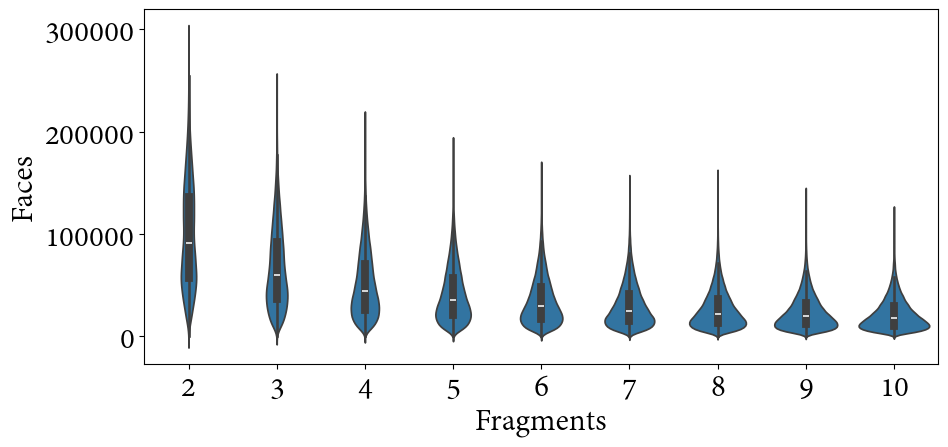

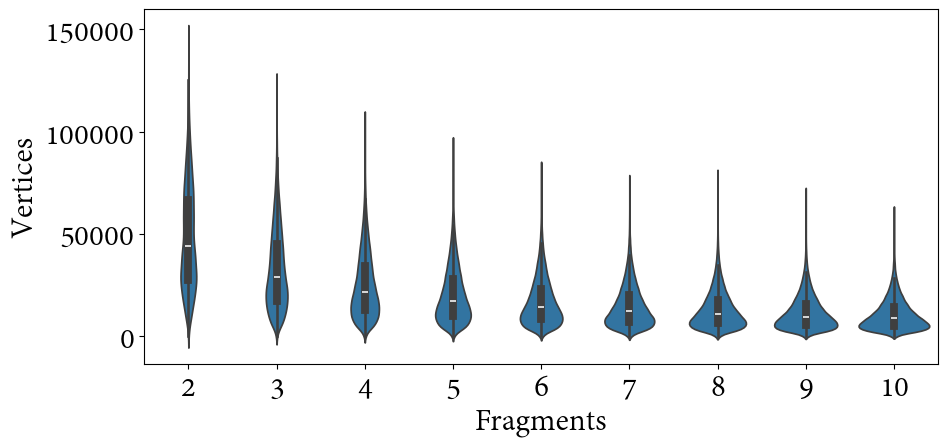

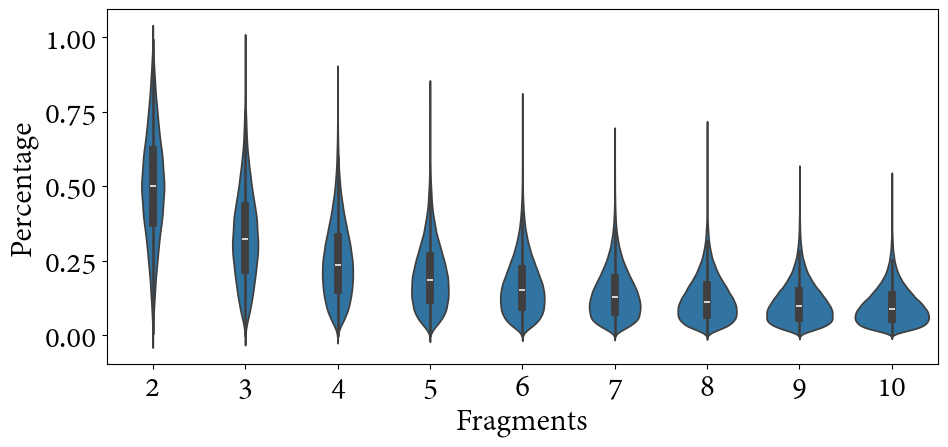

In [15]:
# render violin plot for the number of vertices, one per number of fragments
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.violinplot(x='Fragments', y='Faces', data=global_df, ax=ax)
plt.tight_layout()
plt.savefig('faces_violin.png', dpi=500)
plt.show()

# idem for vertices
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.violinplot(x='Fragments', y='Vertices', data=global_df, ax=ax)
plt.tight_layout()
plt.savefig('vertices_violin.png', dpi=500)
plt.show()

# idem for percentage
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.violinplot(x='Fragments', y='Percentage', data=global_df, ax=ax)
plt.tight_layout()
plt.savefig('percentage_violin.png', dpi=500)
plt.show()

## Storage footprint

In [ ]:
mesh_extension = '.binm'
point_cloud_extension = '.binp'
voxel_extension = '.rle'

In [ ]:
# recursive search
mesh_files = glob.glob(mesh_folder + '**/*' + mesh_extension + '*', recursive=True)
pc_files = glob.glob(mesh_folder + '**/*' + point_cloud_extension + '*', recursive=True)
voxel_files = glob.glob(mesh_folder + '**/*' + voxel_extension + '*', recursive=True)

In [ ]:
len(voxel_files)

In [ ]:
footprint = [ 0, 0, 0]
divisor = 1024 * 1024 * 1024

for file in tqdm(mesh_files):
    footprint[0] += os.path.getsize(file) / divisor

for file in tqdm(pc_files):
    footprint[1] += os.path.getsize(file) / divisor
    
for file in tqdm(voxel_files):
    footprint[2] += os.path.getsize(file) / divisor

In [ ]:
footprint